[<img src="https://www.scenerepresentations.org/assets/logo/logo+text-negative@2x.png" alt="TODO: make logo work better on Colab background" width="212"/>](https://www.scenerepresentations.org)

[`MIT 6.S980, Machine Learning for Inverse Graphics`](https://www.scenerepresentations.org/courses/inverse-graphics/), Prof. Vincent Sitzmann
# Optional PyTorch Intro

**There is nothing in this notebook you will be graded on. If you are already a PyTorch expert (and you already know einsum), feel free to skip to the homework.**

### Contributors
- _Prof. Vincent Sitzmann, Scene Representation Group_
- _Prafull Sharma_
- _Ludwig Schubert_
- _David Charatan_

### Imports

In [1]:
!pip install einops
from einops import einsum

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np

# To make code more readable: some helpful Python 3 type hints
from typing import Callable, List, Optional, Tuple

PyTorch is an open-source machine learning framework. It's a package that offers convenient functions to perform GPU-accelerated computations with vectors and matrices and is the de-facto standard (together with JAX) for machine learning research.

Outside of Google colab, you can install it by following the instructions [here](https://pytorch.org/get-started/locally/).

Colab comes equipped with PyTorch. Let's import it:

In [3]:
import torch
print(f"Installed Torch version: {torch.__version__}")

Installed Torch version: 2.3.0+cu121


## Vectors & Matrices
Vectors and matrices are represented as `torch.Tensor` types. A `torch.Tensor` is very similar to a numpy array. Here is an example of a vector $x \in \mathbb{R}^3$ and a matrix $A \in \mathbb{R}^{3 \times 3}$:

In [4]:
x = torch.tensor([1, 2, 3])
print(x)

tensor([1, 2, 3])


The python class is called `torch.Tensor` (note capital "T"), but to initialize one from existing data we use the constructor function `torch.tensor`.

We will often print a tensor's shape in these homework notebooks. We do this so the information is saved after running the notebook — when you are developing your own code, note that you can just hover over an instantiated tensor in Colab to show its shape! There's also a visual "Variable inspector", click the "{x}" button on the left toolbar, or open the command palette (⌘/Ctrl⇧P) and search for "Show variable Inspector".

In [5]:
A = torch.tensor([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]])
print(A)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])


You can easily convert torch tensors to numpy arrays by calling `.numpy()` on them:

In [6]:
A.numpy()

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

As seen above, you can easily create PyTorch tensors from NumPy arrays or Python lists by simply calling the torch.Tensor() constructor on them. Other useful constructors that all take the *shape* of the tensor as parameter are:

In [7]:
shape = (5, 5)
t0 = torch.zeros(shape) # tensor filled with zeros
t1 = torch.ones(shape)  # tensor filled with ones
tN = torch.randn(shape) # tensor values drawn from the standard normal distribution N(0,1)

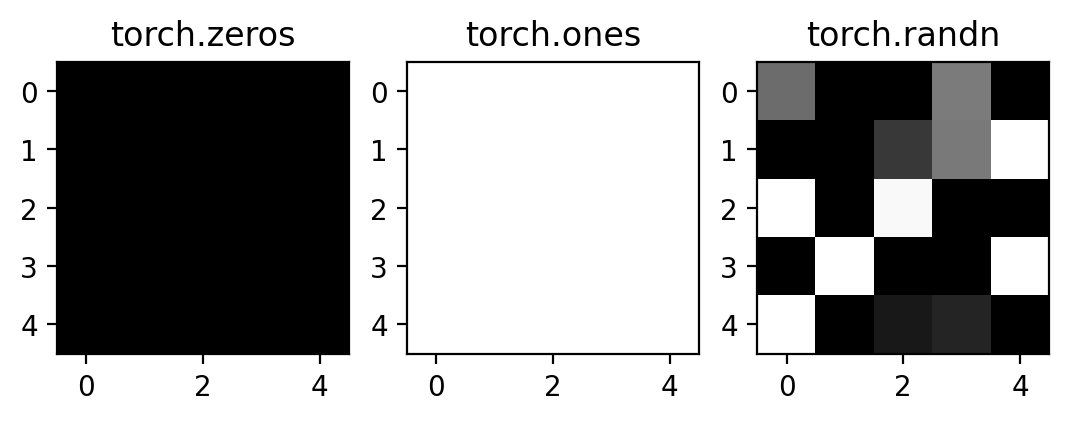

In [8]:
fig, axes = plt.subplots(1, 3)
for t, name, axis in zip((t0, t1, tN), ('torch.zeros', 'torch.ones', 'torch.randn'), axes):
    axis.set_title(name)
    axis.imshow(t, vmin=0, vmax=1, cmap='gray')

Just like numpy arrays, Torch tensors can have different data types. The most common ones are floating point numbers (`float32`) and signed integers (`int`). A tensor's data type is accessible via the `dtype` property like in numpy. You can easily explicitly cast tensors to a different data type by calling `.float()` or `.int()` on them:

In [12]:
A.dtype

torch.int64

In [13]:
A.float() # or A.type(torch.float32)

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [14]:
A.int() # or A.type(torch.int32)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]], dtype=torch.int32)

Note the missing dot (".") after tensor entries, indicating an integer dtype.

The shapes of a tensor can be accessed via the `shape` property:

In [15]:
print(x.shape, A.shape)

torch.Size([3]) torch.Size([3, 3])


## PyTorch Devices

A tensor's data is stored on a `device`, such as your GPU memory or your machine's RAM if using CPU. You can display where a tensor is stored by calling `.device()` on it, and manually copy it to a different device by calling `.to()`. This can be important when calculating data on a GPU, but wanting to plot the results locally. You will often see this written in the short form `.cpu()` in conjunction with converting to a NumPy array.

In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(device)

cuda:0


By copying over all participating tensors to GPU, we can perform GPU-accelerated computations in PyTorch. Below, we perform a convolution on an image from the internet.

<ipython-input-18-2cdfe5bc86b7>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread("https://upload.wikimedia.org/wikipedia/commons/thumb"+


torch.Size([1, 1, 1976, 1916])
Tensor torch_result is stored on device: cuda:0


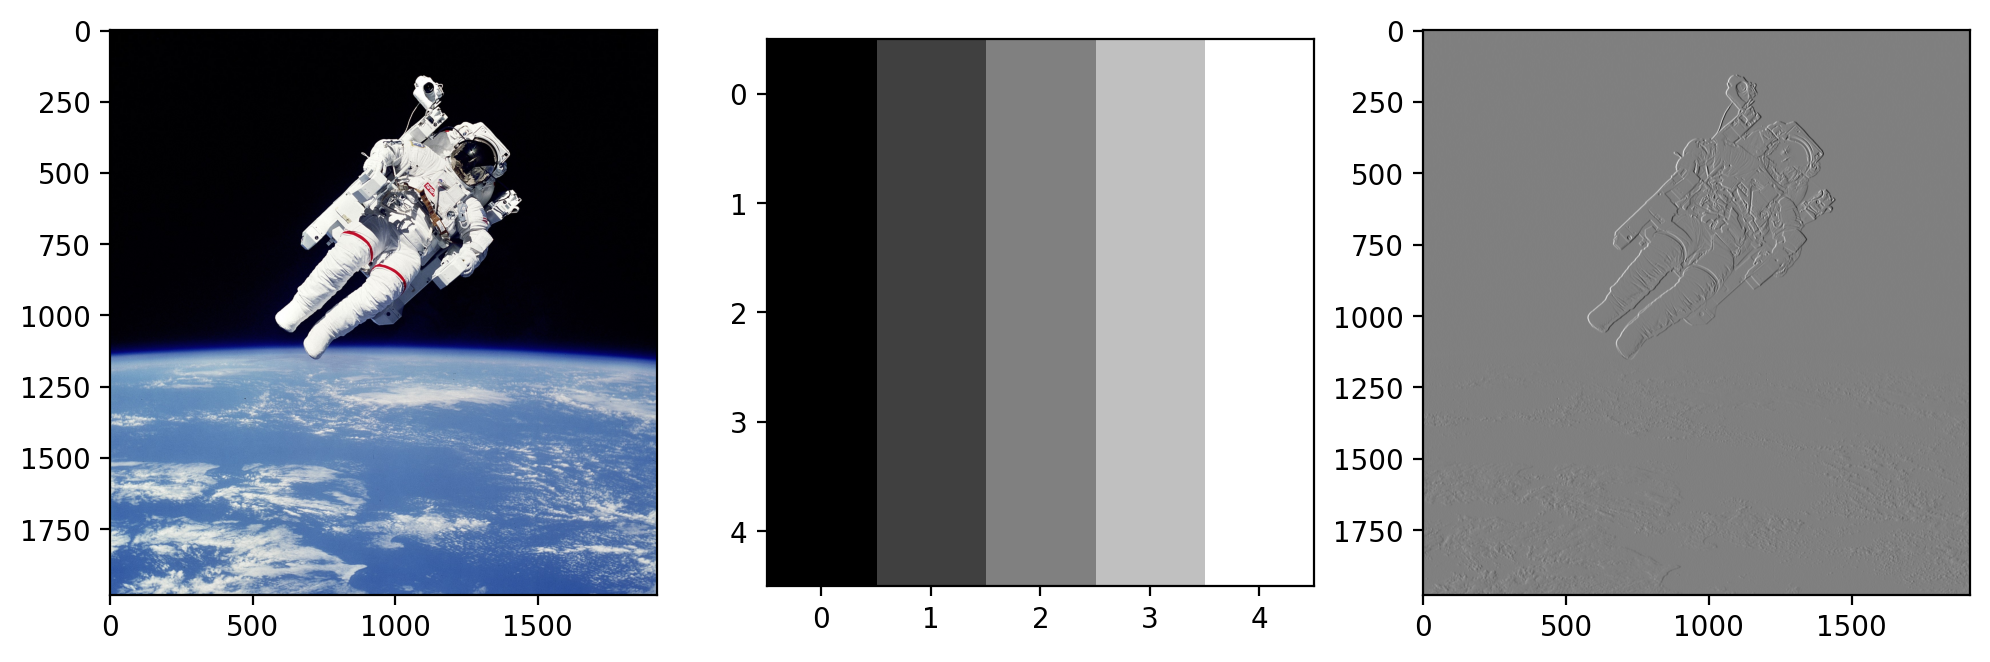

In [18]:
from IPython.core.pylabtools import figsize
# example of copying tensors to and from GPU
import imageio
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
image = imageio.imread("https://upload.wikimedia.org/wikipedia/commons/thumb"+
                       "/5/50/STS41B-35-1613_-_Bruce_McCandless"+
                       "_II_during_EVA_%28Retouched%29.jpg/1920px-STS41B-35-1613_-_Bruce_McCandless_II_during_EVA_%28Retouched%29.jpg")
ax1.imshow(image)

# we'll make up a convolutional filter for this example
filter = torch.linspace(-1,1, steps=5).repeat(5, 1)
ax2.imshow(filter.numpy(), cmap='gray')

# transform both tensors into expected shapes and dtypes:
# `torch.conv2d` expects "B Ci Hi Wi" for the input and "Co Ci Hk Wk" for the kernel
conv_kernel = filter.expand(1, 3, 5, 5).float()
torch_image = torch.tensor([image]).permute(0,3,1,2).float()

# note explicit copying to GPU (`.to(device)`)
torch_result = torch.conv2d(torch_image.to(device), conv_kernel.to(device))
print(torch_result.shape)
# note copying back to CPU (`.cpu()`)
numpy_result = torch_result.cpu()[0][0].numpy()
ax3.imshow(numpy_result, cmap='gray')

print(f"Tensor torch_result is stored on device: {torch_result.device}")

Accessing the GPU tensor's memory directly from your python code with runs on your CPU will throw:

In [19]:
try:
    ax3.imshow(torch_result[0][0], cmap='Greys')
except TypeError as error:
    print("As expected direct access doesn't work:", error)

As expected direct access doesn't work: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


## Tensor Products & Einsum Notation

We will regularly need to compute a variety of vector products with tensors. While PyTorch has conventional functions for matrix-vector and matrix-matrix products, we encourage you to use the `einsum` function from `einops`. **However, if you're finding that using `einsum` is too time-consuming, you're free to use the regular matrix multiplication operator `@` instead. All of the homeworks can be completed using `@` instead of `einsum`.**

The `einsum` function has the following signature:

```python
einsum(*tensors, pattern)
```

The pattern describes the operation `einsum` performs. The pattern consists of comma-separated input tensor shapes, which are each represented by a set of whitespace-separated dimensions; an arrow (`->`); and an output tensor shape, which is also represented by whitespace-separated dimensions. Here's an example:

```python
"i j, j k -> i k"
```

The pattern can also have longer names. For example, this pattern would be equivalent:

```python
"apple orange, orange banana -> apple banana"
```

The left side of the arrow names the axes of all of the input tensors. Tensors are comma-separated, and axes are whitespace-separated. In the above case, the input tensors each have two axes.

The right side of the arrow names the axes that remain in the output tensor. All axes that are missing have been contracted via a dot product. In this case, the axis `j` (a.k.a. `orange`) appears in the two input vectors, but not on the right-hand side, which means that we contracted (i.e., dot-multiplied) the columns of the first tensor with the rows of the second tensor.

It's easiest to learn `einsum` syntax through examples. Here are some examples:

### Matrix-matrix Multiplication

This is one extremely common use case. For example, it appears when applying a transformation to a camera extrinsics matrix.

In [20]:
a = torch.randn((3, 4))
b = torch.randn((4, 5))

assert torch.allclose(
    a @ b,
    einsum(a, b, "i j, j k -> i k"),
)

### Batched Matrix-matrix Multiplication

`einsum` supports arbitrary batch axes with ellipses (`...`).

In [21]:
a = torch.randn((128, 3, 4))
b = torch.randn((128, 4, 5))

# Expect an arbitrary number of batch dimensions (including none).
assert torch.allclose(
    a @ b,
    einsum(a, b, "... i j, ... j k -> ... i k"),
)

# Expect a single batch dimension.
assert torch.allclose(
    a @ b,
    einsum(a, b, "batch i j, batch j k -> batch i k"),
)

### Matrix-vector Multiplication

This is another extremely common use case. For example, it appears when applying a transformation to a point.

In [22]:
a = torch.randn((3, 4))
b = torch.randn((4,))

assert torch.allclose(
    a @ b,
    einsum(a, b, "i j, j -> i"),
)

### Batched Matrix-vector Multiplication

Batched matrix-vector multiplication with the regular matrix multiplication operator `@` is annoying because an $n$-dimensional vector has to be converted to shape $(n, 1)$ before multiplication. `einsum` avoids this.

In [23]:
a = torch.randn((128, 3, 4))
b = torch.randn((128, 4))

assert torch.allclose(
    (a @ b[..., None])[..., 0],
    einsum(a, b, "... i j, ... j -> ... i"),
)

### Matrix-matrix Multiplication with Transpose

`einsum` makes it easy to transpose and matrix-multiply at the same time. Named axes (e.g., using `h`, `w`, `c`, and `b` to mean "height," "width," "channel," and "batch") make it clear what's happening.

In [24]:
a = torch.randn((5, 5, 4, 5))
b = torch.randn((4, 2))

assert torch.allclose(
    (a.permute((0, 1, 3, 2)) @ b).permute((0, 1, 3, 2)),
    einsum(a, b, "h w c b, c f -> h w f b")
)

### More Than Two Inputs

`einsum` can have more than two inputs. For example, one could evaluate $x^T \Sigma x$, where $x$ is a (possibly batched) vector and $\Sigma$ is a (possibly batched) square matrix, as follows. Note how `einsum` makes it easy to handle the batch dimension in `x`.

In [37]:
x = torch.randn((64, 3))
covariance = torch.eye(3)

assert torch.allclose(
    (x[:, None] @ covariance @ x[..., None])[..., 0, 0],
    einsum(x, covariance, x, "... i, ... i j, ... j -> ...")
)

In [36]:
a = np.array([[1, 2, 3], [4, 5, 6], [3,4,7]])
b = np.array([10, 20, 30])

# Adding a new axis to array b
b_new = b[:,None]
print("Array a:")
print(a)

print("\nArray b with a new axis:")
print(b_new)

# Broadcasting addition
result = a + b_new

print("\nResult of broadcasting addition:")
print(result)


Array a:
[[1 2 3]
 [4 5 6]
 [3 4 7]]

Array b with a new axis:
[[10]
 [20]
 [30]]

Result of broadcasting addition:
[[11 12 13]
 [24 25 26]
 [33 34 37]]


## Batching & broadcasting

We usually want to write batched code. This means that we generally expect our tensors to have one or more leading batch dimensions. Assume, for instance, that our dataset consists of *many point clouds*, each of which has 1000 3-dimensional points. A *batch of point clouds* would then be a tensor of shape (batch_size, num_points, 3):

In [38]:
batch_size = 10
num_points = 1000
pc_batch = torch.zeros((batch_size, num_points, 3)).float()
print(pc_batch.shape)

torch.Size([10, 1000, 3])


If we wanted to multiply *all* the point clouds in this batch with the matrix $A \in \mathbb{R}^{3\times3}$, einsum makes this easy:

In [39]:
A = torch.randn((3, 3))

pc_batch_transformed = einsum(pc_batch, A, "b n j, i j -> b n i")
print(pc_batch_transformed.shape)

torch.Size([10, 1000, 3])


Recall that `einsum` supports also supports arbitrary/multiple batch dimensions.

In [40]:
A = torch.randn((3, 3))

pc_batch_transformed = einsum(pc_batch, A, "... n j, i j -> ... n i")
print(pc_batch_transformed.shape)

torch.Size([10, 1000, 3])
